# Plant Disease Prediction
---
**What does this Project do?**
- This project builds up a program to automatically predict the plant disease with images using Convolutional Neural Network model 

**What is the Business Impact & Purpose of this Project?**
- This program can help different agricultural firms and farmers to increase their yield and stop wastage of crops due to disease


**How to Build Up this Project?**

1. Import libraries
2. Visualize the images and check the dataset
3. Find the mean of the dimensions and resizing all images accordingly
4. Convert the images into a numpy array and normalize them
5. Check class imbalance
6. Split the data and perform one-hot encoding
7. Create the CNN model architecture and compile the model and fit it
8. Plot the accuracy and loss against each epoch
9. Preporcess the test data and make predictions on it
10. Visualize the original and predicted labels for the test images
---

## Import Libraries & Images Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import cv2
import random
import os
from os import listdir
from PIL import Image

from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

> - The images are stored in the `./Data/Plant_images_pianalytix` folder

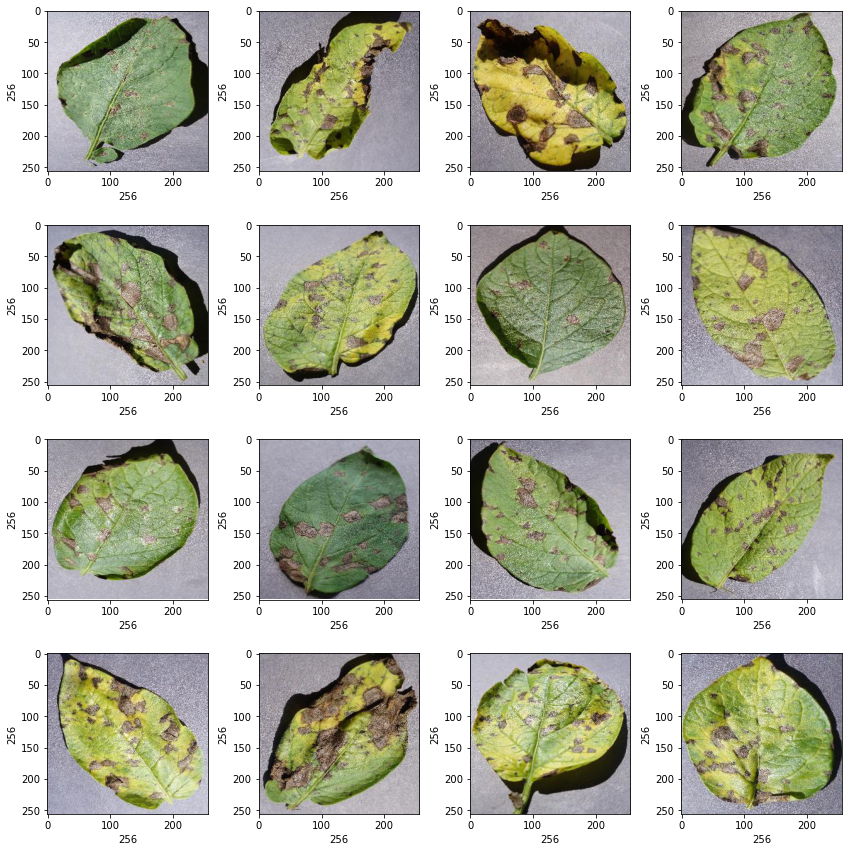

In [2]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "./Data/Plant_images_pianalytix/Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10) # width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10) # height of image

## Data Preprocessing

In [3]:
# Converting Images to array for normalization
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
dir = "./Data/Plant_images_pianalytix"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
    plant_image_list = listdir(f"{dir}/{directory}")
    temp += 1
    for files in plant_image_list:
        image_path = f"{dir}/{directory}/{files}"
        image_list.append(convert_image_to_array(image_path))
        label_list.append(binary_labels[temp])

In [5]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    300
1    300
2    300
dtype: int64

> - Three kinds of images (labels) are in same number of classes count

In [6]:
image_list[0].shape

(256, 256, 3)

In [7]:
label_list = np.array(label_list)
label_list.shape

(900,)

> - The shape of one image is (256, 256, 3) in numpy array
> - The length of the labels list is 900, so there are 900 images

In [8]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

In [9]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

> - Use `train_test_split` to split the dataset into 80% training & 20% testing sets
> - Divide each image pixel with 255, to normalize the dataset, as pixel values range from 0 to 255
> - Use `to_categorical` to make labels into categories

## Create Model

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))

model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 225800    
_________________________________________________________________
dense_1 (Dense)       

2022-06-15 23:22:41.576671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 23:22:41.576775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


> 1. Create a `network architecture` for the model with different types of layers based on their features
> - `Conv_2d` (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor)
> - `max_pooling2d` (It is a downsampling technique which takes out the maximum value over the window defined by poolsize)
> - `flatten` (It flattens the input and creates a 1D output)
> - `Dense` (Dense layer produce the output as the dot product of input and kernel)


In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

> 2. Compile the model
> - Set the type of loss (Binary Crossentropy)
> - Also need to set the optimizer and the metrics respectively

In [13]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [14]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val))

2022-06-15 23:29:21.813418: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-15 23:29:21.813594: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-15 23:29:21.946363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
5/5 [==============================] - 2s 358ms/step - loss: 1.1402 - accuracy: 0.3281 - val_loss: 1.0441 - val_accuracy: 0.4306


2022-06-15 23:29:23.708745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50
5/5 [==============================] - 1s 257ms/step - loss: 1.0418 - accuracy: 0.4965 - val_loss: 0.9825 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - 1s 262ms/step - loss: 0.9536 - accuracy: 0.6198 - val_loss: 0.8963 - val_accuracy: 0.5903
Epoch 4/50
5/5 [==============================] - 1s 256ms/step - loss: 0.8604 - accuracy: 0.6111 - val_loss: 0.7981 - val_accuracy: 0.6736
Epoch 5/50
5/5 [==============================] - 1s 256ms/step - loss: 0.7799 - accuracy: 0.6840 - val_loss: 0.7300 - val_accuracy: 0.7500
Epoch 6/50
5/5 [==============================] - 1s 249ms/step - loss: 0.7117 - accuracy: 0.7535 - val_loss: 0.6568 - val_accuracy: 0.7222
Epoch 7/50
5/5 [==============================] - 1s 248ms/step - loss: 0.6588 - accuracy: 0.7378 - val_loss: 0.6228 - val_accuracy: 0.8403
Epoch 8/50
5/5 [==============================] - 1s 255ms/step - loss: 0.6187 - accuracy: 0.8281 - val_loss: 0.5742 - val_accuracy: 0.7847
Epoch 9/50
5/5 [====

> 3. Fit the model with the data and find out the accuracy at each epoch to see how the model is learning
> - Train the model with 50 epochs and 128 batch_size
> - During each epochs, it will show how the model is performing by viewing the training & validation accuracy

In [15]:
# Save the model to .h5
model.save("./Data/plant_disease.h5")

# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('./Data/plant_model.json', 'w') as json_file:
    json_file.write(json_model)
    
# save the weights of the model
model.save_weights('./Data/plant_model_weights.h5')

## Model Evaluation

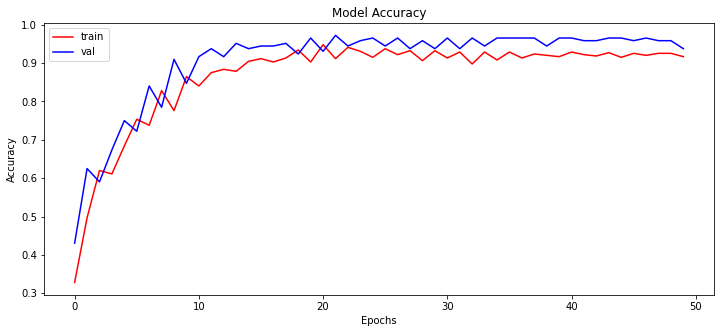

In [16]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [17]:
# Plot the accuracy of the model for the training history
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 0s 22ms/step - loss: 0.3853 - accuracy: 0.9333
Test Accuracy: 93.33333373069763


In [18]:
# Use the model to predict the testing set
y_pred = model.predict(x_test)

2022-06-15 23:31:44.621198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


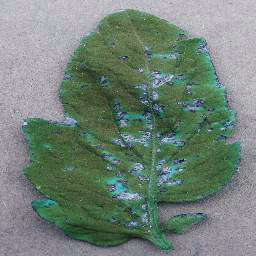

In [19]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [20]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted : ",all_labels[np.argmax(y_pred[10])])

Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight


## Final Results

In [21]:
def compare_original_and_predicted(num):
    img = array_to_img(x_test[num])
    original_label = all_labels[np.argmax(y_test[num])]
    predicted_label = all_labels[np.argmax(y_pred[num])]
    result = "Success" if original_label == predicted_label else "False"
    
    display(img)
    
    print("Prediction Result: ", result)
    print("Originally : ",all_labels[np.argmax(y_test[num])])
    print("Predicted : ",all_labels[np.argmax(y_pred[num])])

----------0 Image in testing set ----------


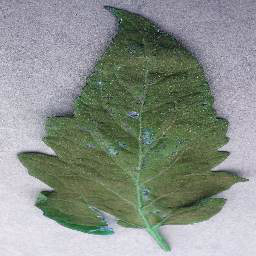

Prediction Result:  Success
Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight
-----------------------------------------------

----------1 Image in testing set ----------


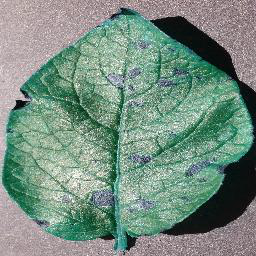

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------2 Image in testing set ----------


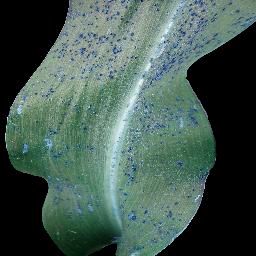

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------3 Image in testing set ----------


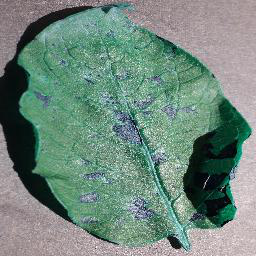

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------4 Image in testing set ----------


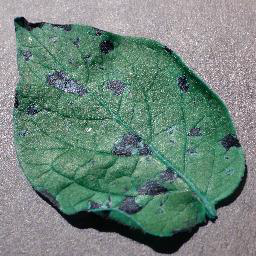

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------5 Image in testing set ----------


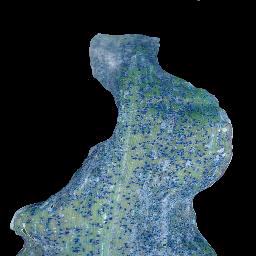

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------6 Image in testing set ----------


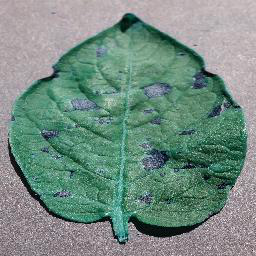

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------7 Image in testing set ----------


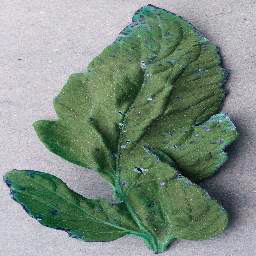

Prediction Result:  Success
Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight
-----------------------------------------------

----------8 Image in testing set ----------


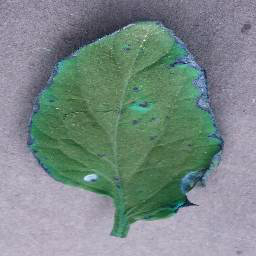

Prediction Result:  Success
Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight
-----------------------------------------------

----------9 Image in testing set ----------


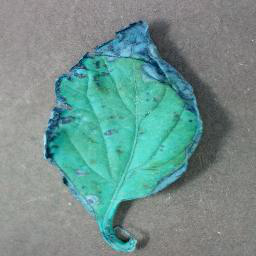

Prediction Result:  False
Originally :  Potato-Early_blight
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------10 Image in testing set ----------


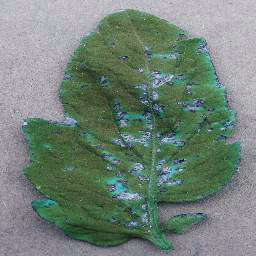

Prediction Result:  Success
Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight
-----------------------------------------------

----------11 Image in testing set ----------


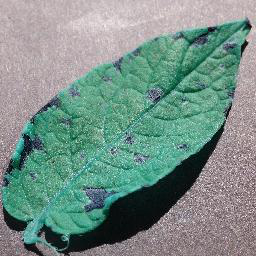

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------12 Image in testing set ----------


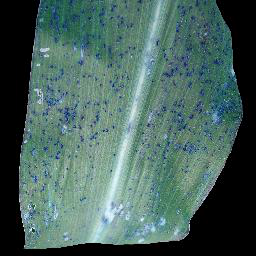

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------13 Image in testing set ----------


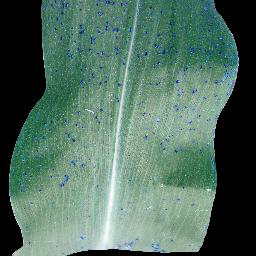

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------14 Image in testing set ----------


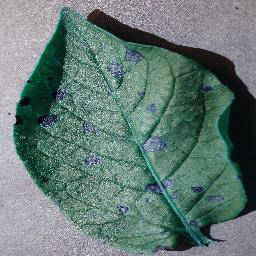

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------15 Image in testing set ----------


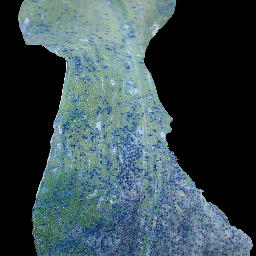

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------16 Image in testing set ----------


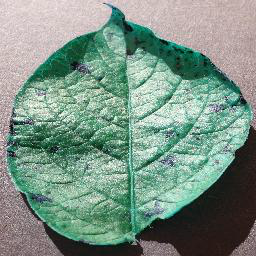

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------17 Image in testing set ----------


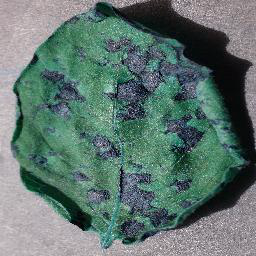

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------18 Image in testing set ----------


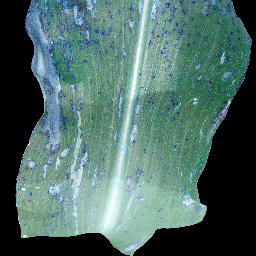

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------19 Image in testing set ----------


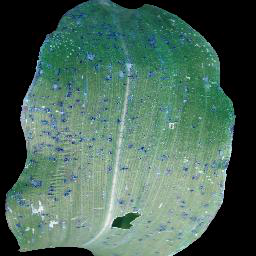

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------20 Image in testing set ----------


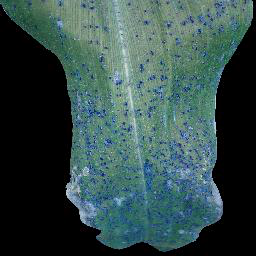

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------21 Image in testing set ----------


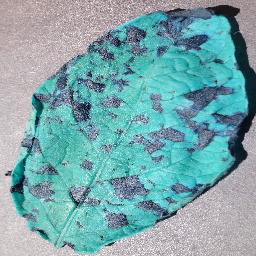

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------22 Image in testing set ----------


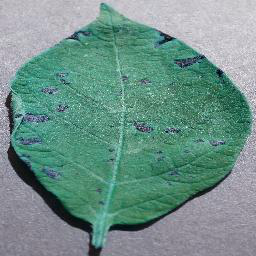

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------

----------23 Image in testing set ----------


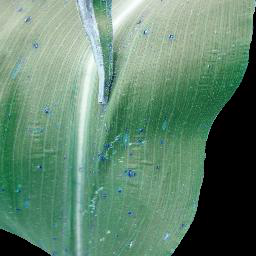

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------24 Image in testing set ----------


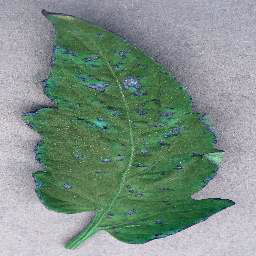

Prediction Result:  Success
Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight
-----------------------------------------------

----------25 Image in testing set ----------


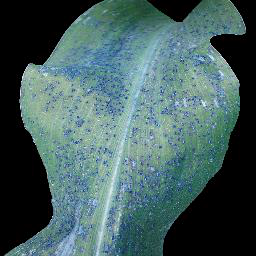

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------26 Image in testing set ----------


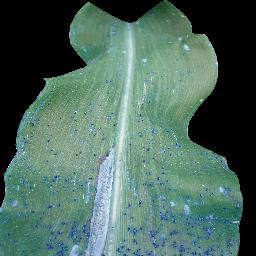

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------27 Image in testing set ----------


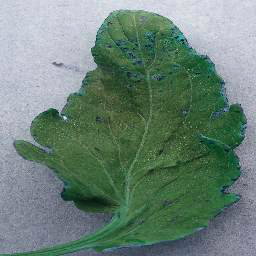

Prediction Result:  Success
Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight
-----------------------------------------------

----------28 Image in testing set ----------


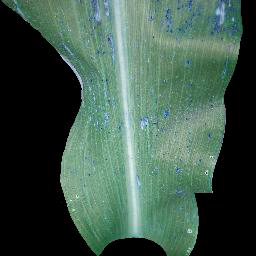

Prediction Result:  Success
Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
-----------------------------------------------

----------29 Image in testing set ----------


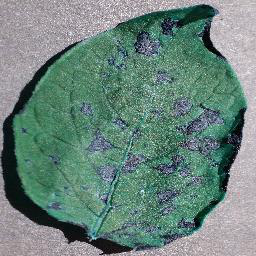

Prediction Result:  Success
Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
-----------------------------------------------



In [22]:
for num in range(30):
    print(f"----------{num} Image in testing set ----------")
    compare_original_and_predicted(num)
    print("-----------------------------------------------\n")